In [29]:
from __future__ import annotations

from pathlib import Path

import dill
import numpy as np
import rich
from matbench_discovery.enums import MbdKey
from matbench_discovery.metrics import stable_metrics
from pymatviz import Key
from tqdm.auto import tqdm

results_dir = Path("/workspaces/jmp-backbone/notebooks/results/epoch2-step57398v2/")
results = list(results_dir.glob("*.dill"))
print(f"Found {len(results)} results")

predicted_eform_list: list[float] = []
true_eform_list: list[float] = []

predicted_ehull_list: list[float] = []
true_ehull_list: list[float] = []

for result_path in tqdm(results):
    with result_path.open("rb") as f:
        result = dill.load(f)

    # Ignore non-unique prototypes
    if not result["metadata"][Key.uniq_proto.value]:
        continue

    eform_pred = result["energy"]
    predicted_eform_list.append(eform_pred)

    eform_true = result["metadata"][MbdKey.e_form_wbm.value]
    true_eform_list.append(eform_true)

    hull_true = result["metadata"][MbdKey.each_true.value]
    true_ehull_list.append(hull_true)

    hull_pred = hull_true + (eform_pred - eform_true)
    predicted_ehull_list.append(hull_pred)

predicted_eform = np.array(predicted_eform_list)
true_eform = np.array(true_eform_list)

predicted_ehull = np.array(predicted_ehull_list)
true_ehull = np.array(true_ehull_list)

rich.print(stable_metrics(true_ehull, predicted_ehull))

Found 1000 results


  0%|          | 0/1000 [00:00<?, ?it/s]

{
    'F1': 0.6816143497757847,
    'DAF': 5.4031746031746035,
    'Precision': 0.8444444444444444,
    'Recall': 0.5714285714285714,
    'Accuracy': 0.9165687426556992,
    'TPR': 0.5714285714285714,
    'FPR': 0.019498607242339833,
    'TNR': 0.9805013927576601,
    'FNR': 0.42857142857142855,
    'TP': 76,
    'FP': 14,
    'TN': 704,
    'FN': 57,
    'MAE': 0.10326749340800698,
    'RMSE': 0.2094582092309482,
    'R2': -0.2493030672864207
}

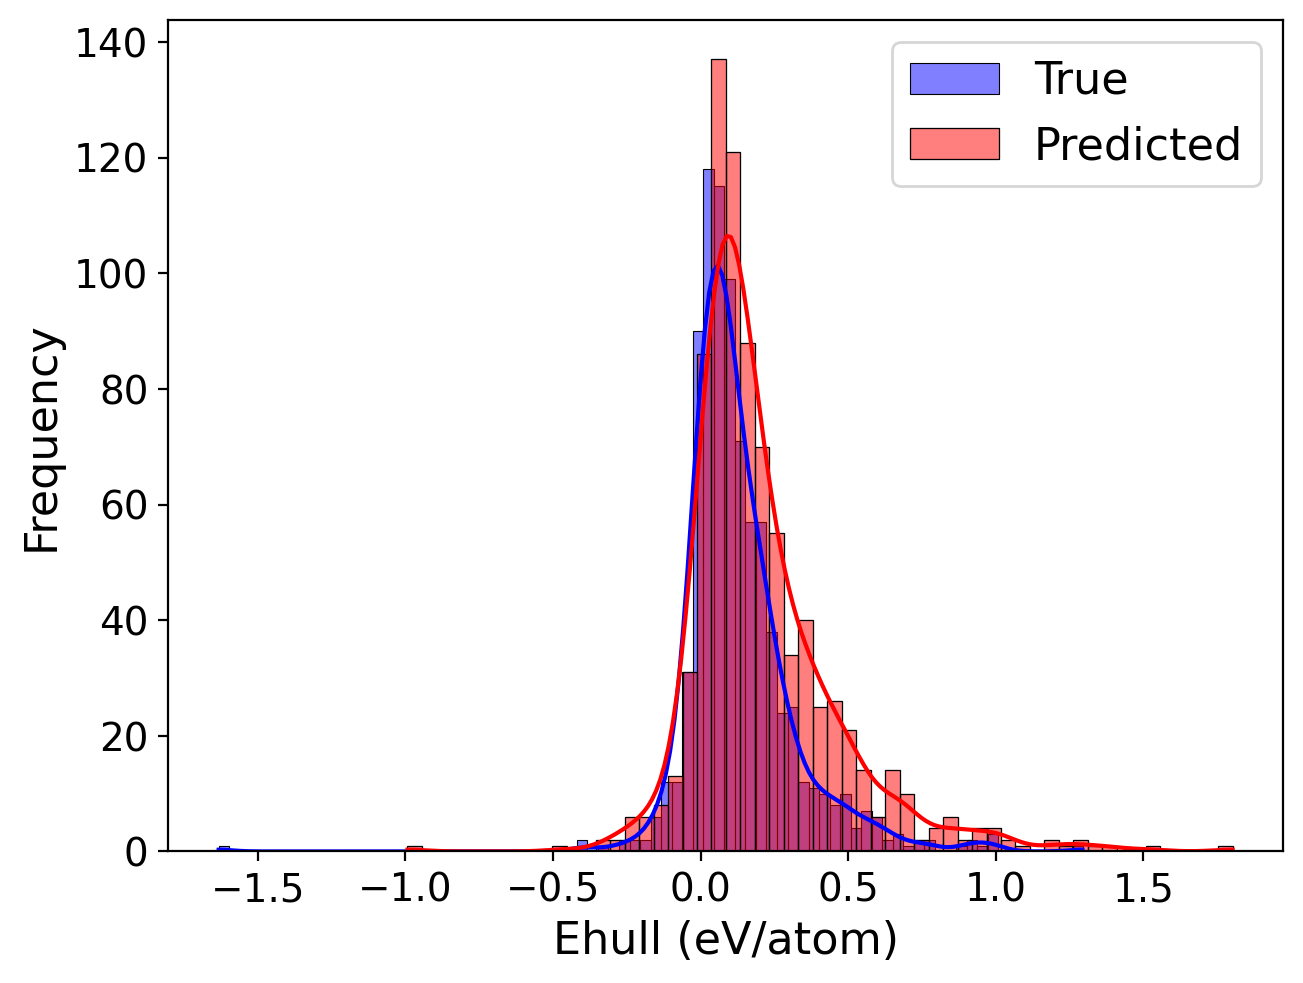

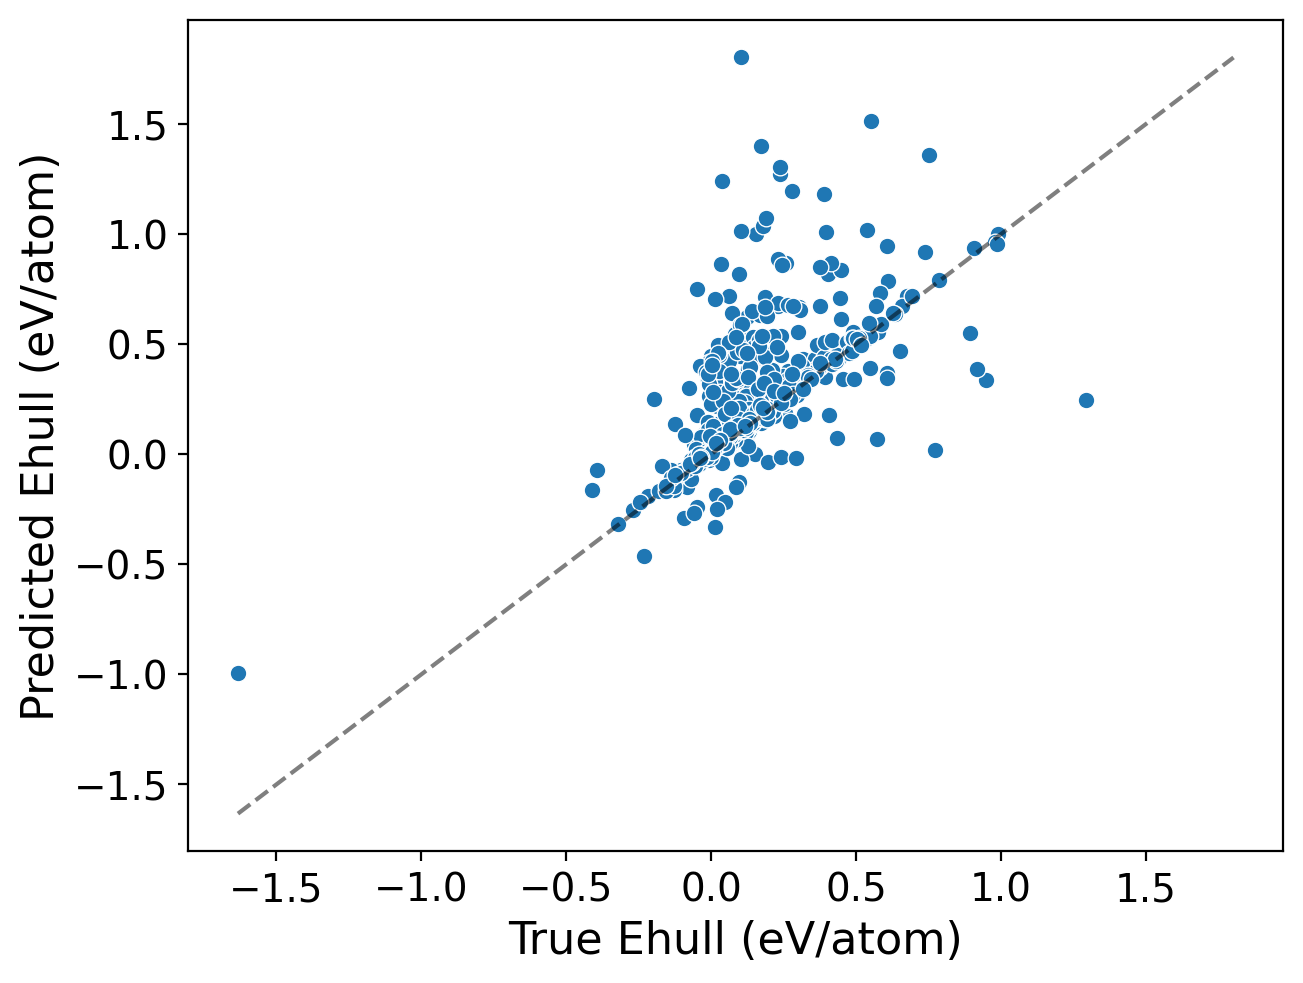

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots()

sns.histplot(true_ehull, kde=True, color="blue", label="True", ax=ax)
sns.histplot(predicted_ehull, kde=True, color="red", label="Predicted", ax=ax)

ax.set_xlabel("Ehull (eV/atom)")
ax.set_ylabel("Frequency")
ax.legend()
plt.show()

# Now, draw a scatter plot of true vs predicted Ehull
fig, ax = plt.subplots()

sns.scatterplot(x=true_ehull, y=predicted_ehull, ax=ax)
ax.set_xlabel("True Ehull (eV/atom)")
ax.set_ylabel("Predicted Ehull (eV/atom)")

# Draw a 1:1 line
min_val = min(true_ehull.min(), predicted_ehull.min())
max_val = max(true_ehull.max(), predicted_ehull.max())
ax.plot(
    [min_val, max_val],
    [min_val, max_val],
    color="black",
    linestyle="--",
    label="1:1 line",
    alpha=0.5,
)

plt.show()
